# Importing Necessary Libraries

In [1]:
!pip install tensorflow-addons==0.8.3
#!pip install tensorflow==2.2.0-rc3


     |████████████████████████████████| 1.0 MB 5.3 MB/s 


In [2]:
!pip install --upgrade tensorflow

In [3]:
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 489.6 MB 22 kB/s 


In [5]:
# Don't run this cell
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# Debug
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow import keras

from IPython.display import Image, display
import matplotlib.cm as cm

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Don't R
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [8]:
import torch
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# Geting our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!rm -rf dataset

In [12]:
ls

drive/  sample_data/


In [13]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.7.0


In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Pre Processing

In [11]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented']


In [12]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 100
IMAGE_SIZE = [IMG_SIZE, IMG_SIZE]
DIM = (IMG_SIZE, IMG_SIZE)

In [13]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=True)

Found 6400 images belonging to 4 classes.


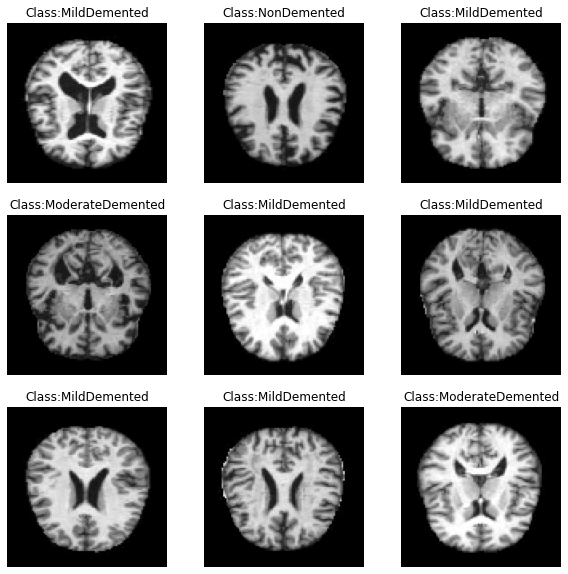

In [17]:
def show_images(generator,y_pred=None, nn=6400):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, nn)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen,nn=6400)

In [14]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [15]:
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(6400, 100, 100, 3) (6400, 4)


In [16]:
print(len(train_data))

6400


In [17]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [18]:
# OVER SAMPLING
# - train data
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(8236, 100, 100, 3) (8236, 4)


In [19]:
# OVER SAMPLING
# - validation data
val_data, val_labels = sm.fit_resample(val_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), val_labels)

val_data = val_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(val_data.shape, val_labels.shape)

(2020, 100, 100, 3) (2020, 4)


In [20]:
# OVER SAMPLING
# - test data
test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)

test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(test_data.shape, test_labels.shape)

(2544, 100, 100, 3) (2544, 4)


In [21]:
def conv_block(filters, act='relu',i=0):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_p{i}'))
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_pp{i}'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [22]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [23]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),     
        MaxPool2D(), 
#         conv_block(32,i=1),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_p1'),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_pp1'),
        BatchNormalization(),
        MaxPool2D(),
        
#         conv_block(64,i=2),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_p2'),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_pp2'),
        BatchNormalization(),
        MaxPool2D(), 
        
#         conv_block(128,i=3),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_p3'),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_pp3'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
#         conv_block(256,i=4),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_p4'),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_pp4'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [24]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [34]:
#Defining other parameters for our CNN model

#model = construct_model()

#METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           #tf.keras.metrics.AUC(name='auc'), 
           #tfa.metrics.F1Score(num_classes=4)]

#CALLBACKS = [my_callback]

#model.cuda()
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/GPU:0'):
  model = construct_model()

  METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

  CALLBACKS = [my_callback]
  
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_p1 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 conv2d_pp1 (Conv2D)         (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_35 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                        

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3704673602622905133
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11304370176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10329562378845688181
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [35]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 150

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/150


UnknownError: ignored

# Basic

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU
